In [1]:
# Loading in the basics
import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from config import password

In [2]:
# Connect to postgres db
ENDPOINT="ucb-data-group-project-zillow.csaw135fqqkl.us-west-1.rds.amazonaws.com"
PORT="5432"
USR="postgres"
REGION="us-west-1"


In [3]:
DBNAME="postgres"

conn = psycopg2.connect(database = DBNAME,
                        user =     USR,
                        password = password,
                        host =     ENDPOINT,
                        port =     PORT)

In [4]:
# zillow final table sql
zillow_final_sql = '''
            SELECT *
            FROM zillow_final;
            '''

In [5]:
# setting up dfs
zillow_final_data_df = pd.read_sql(zillow_final_sql, conn)

In [6]:
# census table sql
census_sql = '''
            SELECT *
            FROM census;
            '''

In [7]:
# setting up dfs
census_data_df = pd.read_sql(census_sql, conn)

In [8]:
zillow_final_data_df["date"] = pd.to_datetime(zillow_final_data_df["date"])
zillow_final_data_df

,date,size_rank,region_name,list_price,sale_price,list_divided_by_sale,list_minus_sale
0,2017-11-04,0,United States,275448.0,235099.0,85.351500,40349.0
1,2017-11-11,0,United States,275448.0,234750.0,85.224797,40698.0
2,2017-11-18,0,United States,275448.0,235750.0,85.587842,39698.0
3,2017-11-25,0,United States,274975.0,235916.0,85.795436,39059.0
4,2017-12-02,0,United States,274825.0,237166.0,86.297098,37659.0
...,...,...,...,...,...,...,...
2207,2021-05-22,17,"San Diego, CA",849925.0,745500.0,87.713622,104425.0
2208,2021-05-22,13,"Riverside, CA",536250.0,482000.0,89.883450,54250.0
2209,2021-05-22,11,"San Francisco, CA",995660.0,1092750.0,109.751321,-97090.0
2210,2021-05-22,2,"Los Angeles-Long Beach-Anaheim, CA",999750.0,816125.0,81.632908,183625.0


In [9]:
#full yearly dataframes
df_2017 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2017-01-01") & (zillow_final_data_df["date"] <= "2017-12-31")]
df_2018 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2018-01-01") & (zillow_final_data_df["date"] <= "2018-12-31")]
df_2019 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2019-01-01") & (zillow_final_data_df["date"] <= "2019-12-31")]
df_2020 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2020-01-01") & (zillow_final_data_df["date"] <= "2020-12-31")]
df_2021 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2021-01-01") & (zillow_final_data_df["date"] <= "2021-12-31")]

df_2017

,date,size_rank,region_name,list_price,sale_price,list_divided_by_sale,list_minus_sale
0,2017-11-04,0,United States,275448.0,235099.0,85.351500,40349.0
1,2017-11-11,0,United States,275448.0,234750.0,85.224797,40698.0
2,2017-11-18,0,United States,275448.0,235750.0,85.587842,39698.0
3,2017-11-25,0,United States,274975.0,235916.0,85.795436,39059.0
4,2017-12-02,0,United States,274825.0,237166.0,86.297098,37659.0
...,...,...,...,...,...,...,...
457,2017-12-30,13,"Riverside, CA",391275.0,356438.0,91.096543,34837.0
458,2017-12-30,11,"San Francisco, CA",811943.0,749188.0,92.271009,62755.0
459,2017-12-30,2,"Los Angeles-Long Beach-Anaheim, CA",818914.0,618750.0,75.557385,200164.0
460,2017-12-30,25,"Sacramento, CA",469870.0,393375.0,83.719965,76495.0


In [78]:
# creating single point year by year averages to merge with census data
df_annual = pd.DataFrame(columns = ["list_price", "sale_price", "list_divided_by_sale", "list_minus_sale"])
df_annual.loc["2017"] = df_2017.mean()
df_annual.loc["2018"] = df_2018.mean()
df_annual.loc["2019"] = df_2019.mean()
df_annual.loc["2020"] = df_2020.mean()
df_annual.loc["2021"] = df_2021.mean()

df_annual.to_csv("resources/total_annual_mean.csv")

,list_price,sale_price,list_divided_by_sale,list_minus_sale
2017,583102.644444,491099.404630,84.493022,92003.239815
2018,601525.448077,512144.066506,85.107600,89381.381571
2019,607647.219231,516513.758013,85.075049,91133.461218
2020,666510.093109,552505.598878,83.500384,114004.494231
2021,677736.111063,596916.407328,88.027487,80819.703736


In [40]:
# dividing df into regions

df_united_states = zillow_final_data_df.loc[zillow_final_data_df["region_name"] == "United States"]
df_california = zillow_final_data_df.loc[zillow_final_data_df["region_name"] == "California"].dropna()
df_california_cities =zillow_final_data_df.loc[(zillow_final_data_df["region_name"] != "United States") & (zillow_final_data_df["region_name"] != "California")]

df_california.shape

(186, 7)

In [11]:
# loading libraries for prophet.

from fbprophet import Prophet
import numpy as np
from pandas import DataFrame, to_datetime
from sklearn.metrics import mean_absolute_error


Importing plotly failed. Interactive plots will not work.


In [30]:
df = pd.DataFrame(columns = ["ds", "y"]) # ds, and y are the "expected" options for columns in prophet, ds= datestamp
df["ds"] = df_california_cities.loc[:, "date"]  # changing the dataframe here and the line below will change output
df["y"] = df_california_cities.loc[:, "sale_price"] # change column name for more models
model = Prophet(daily_seasonality = True, yearly_seasonality = True)
# fit the model
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [31]:
future = model.make_future_dataframe(periods = 365) #predicting next year in sale_price of california cities 
for i in range(1, 13):
	date = '2021-%02d' % i 
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

             ds           yhat     yhat_lower    yhat_upper
2200 2022-05-18  684799.269884  358446.856863  9.848246e+05
2201 2022-05-19  684578.556513  365226.052032  9.917943e+05
2202 2022-05-20  684301.622196  364197.856196  1.006606e+06
2203 2022-05-21  683973.855315  360618.334600  1.007527e+06
2204 2022-05-22  683601.872555  368570.815607  1.010245e+06


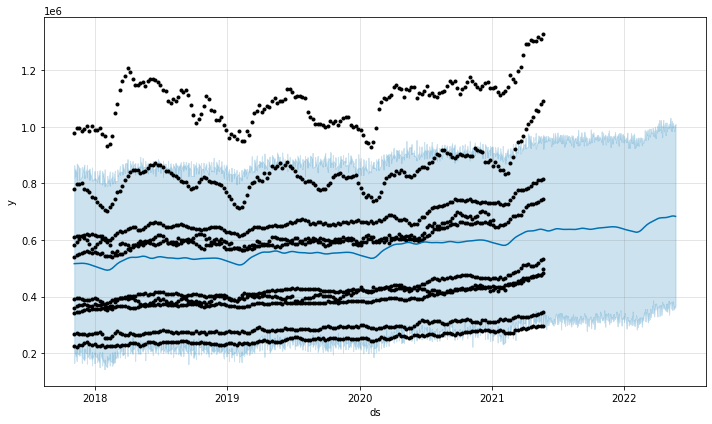

In [32]:
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
model.plot(forecast)
plt.show()

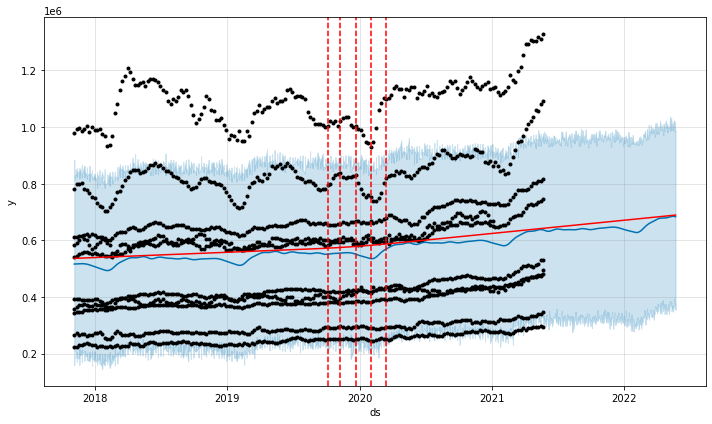

In [16]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast) #default changepoints model

In [33]:
forecast.to_csv("city_forecast.csv")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


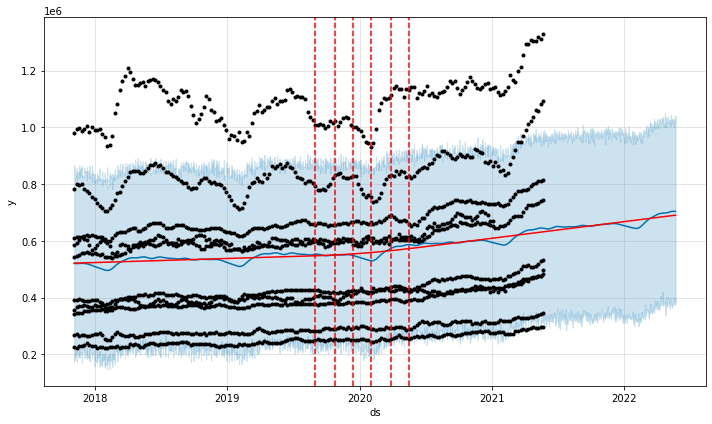

In [17]:
# messing with change_point scaling to double check the tight grouping in previous graph
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08) 
forecast = pro_change.fit(df).predict(future)
fig= pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [ ]:
forecast.to_csv("city_forecast.csv")

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Flatten,LSTM,RepeatVector,TimeDistributed,Conv1D,MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from livelossplot.tf_keras import PlotLossesCallback
from statsmodels.tsa.seasonal import seasonal_decompose

In [42]:
df_1 = pd.DataFrame(columns = ["x", "y"]) # ds, and y are the "expected" options for columns in prophet, ds= datestamp

df_1["x"] = df_california.loc[:,"list_price"]
df_1["y"] = df_california.loc[:,"sale_price"]
df_1.head()

,x,y
186,614123.7,508281.3
187,613946.7,514450.0
188,614898.4,516943.9
189,612118.7,517912.7
190,608753.3,517612.8


In [43]:
def train_test_builder(df,size_test=24,length_train_sequence = 24,length_forecast = 12, normalize = False):
    
    train_df_1 = df_1[:-size_test]    
    
    # create training sets
    train_x,train_y = window_splitter(train_df_1)
    
    # create test set
    tmp = df_1[:length_forecast]
    tmp = pd.concat([df_1,tmp],ignore_index = True)
    tmp[-length_forecast:] = np.nan  # unknown
    test_x,test_y = window_splitter(tmp)
    # drop elements in training
    test_x = test_x[train_x.shape[0]:]
    test_y = test_y[train_x.shape[0]:]
    for i in range(length_forecast):
        test_y[i,:(11-i)]=np.nan # present in training_set
    
    # normalize
    if normalize:
        m = train_df_1.x.mean()
        sd = train_df_1.x.std()
        train_x -= m
        train_x/= sd
        test_x -=m
        test_x /= sd
    
    return train_x,train_y,test_x,test_y


# iterate over the time steps and divide the data into overlapping windows; 
def window_splitter(train_df_1,length_train_sequence = 24,length_forecast = 12):
    i = 0
    x,y = [],[]
    while i + length_train_sequence+ length_forecast < len(train_df_1):
        x.append(train_df_1.x[i:(i+length_train_sequence)].values)
        y.append(train_df_1.x[(i+length_train_sequence):(i+length_train_sequence+length_forecast)].values)
        i+=1

    x = np.array(x).reshape(-1,length_train_sequence,1)
    y = np.array(y).reshape(-1,length_forecast)
    
    return x,y

D:\anaconda\envs\ml_\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


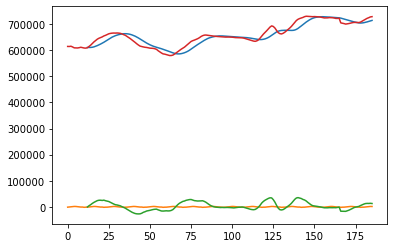

In [44]:
# a naive seasonal decomposition
series = df_1.x.values
result = seasonal_decompose(series, model='additive',freq=12,two_sided = False,)
plt.plot(result.trend)
plt.plot(result.seasonal)
plt.plot(result.resid)
plt.plot(result.observed)

In [45]:
train_x,train_y,test_x,test_y = train_test_builder(df_1)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((126, 24, 1), (126, 12), (36, 24, 1), (36, 12))

In [46]:

# evaluation function
def evaluate_predictions(pred_y, test_y):
    return pd.DataFrame(abs(test_y-pred_y)).mean(skipna = True)


def plot_evaluation(pred_y,test_y,n=12):
    scores = evaluate_predictions(pred_y,test_y)

    print("Mean absolute error test set:",scores.mean())

    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1,13),scores)
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.ylabel("MAE", size = 15)
    plt.title("Scores LSTM on test set")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.title("LSTM forecasting - test set window")
    plt.plot(np.arange(1,13),pred_y[n:(n+1)].reshape(-1,1),label = "predictions")
    plt.plot(np.arange(1,13),test_y[n:(n+1)].reshape(-1,1),label = "true values")
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.legend()
    plt.show()

In [56]:

n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

# define model
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(None, 1)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs))

# compile
model.compile(loss='mse', optimizer= Adam(lr=1e-3), metrics = ["mae"])

# callbacks
early_stopping = EarlyStopping(patience=32, monitor='val_loss', mode='auto', restore_best_weights=True)
callbacks=[PlotLossesCallback(), early_stopping]

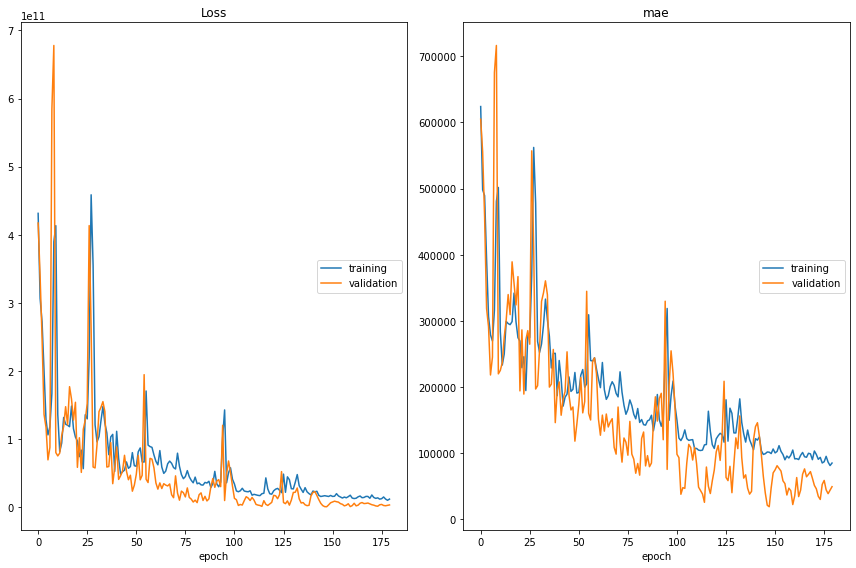

Loss
	training         	 (min: 10059471290.182, max: 458608788945.455, cur: 11798724538.182)
	validation       	 (min: 569949440.000, max: 677885050880.000, cur: 3199375360.000)
mae
	training         	 (min: 81502.656, max: 623928.562, cur: 85292.977)
	validation       	 (min: 19269.971, max: 716238.188, cur: 49600.492)
88/88 [==============================] - 1s 9ms/sample - loss: 11798724538.1818 - mae: 85292.9766 - val_loss: 3199375360.0000 - val_mae: 49600.4922


In [57]:
model.fit(train_x, train_y, 
          validation_split = 0.3, 
          epochs=500, 
          shuffle = True,
          batch_size=50,
          verbose=1,
          callbacks = callbacks,
         )

Mean absolute error test set: 49883.82708333333


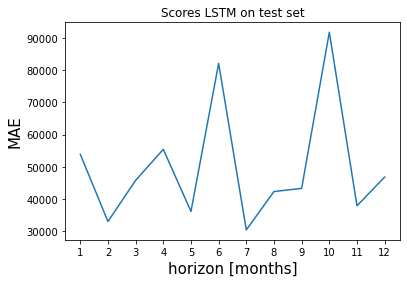

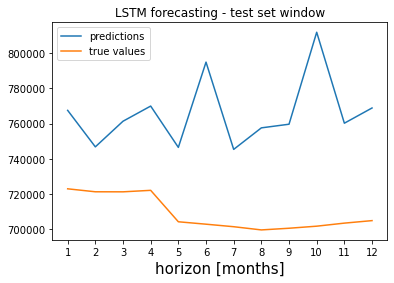

In [58]:
pred_y = model.predict(test_x)
# add seasonality of the past year
for i in np.arange(pred_y.shape[0]-1,-1,-1):
    pred_y[pred_y.shape[0]-1-i] += result.seasonal[-(13+i):-(1+i)]

plot_evaluation(pred_y,test_y,n=12)


In [59]:
tmp = pd.DataFrame(test_y-pred_y)
tmp.columns = np.arange(1,13)

tmp.to_csv("california_state_lstm.csv",index = False)

In [61]:
df_2 = pd.DataFrame(columns = ["ds", "y"]) # ds, and y are the "expected" options for columns in prophet, ds= datestamp
df_2["ds"] = df_california.loc[:, "date"]  # changing the dataframe here and the line below will change output
df_2["y"] = df_california.loc[:, "sale_price"] # change column name for more models
model = Prophet(daily_seasonality = True, yearly_seasonality = True)
# fit the model
model.fit(df_2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


             ds           yhat     yhat_lower     yhat_upper
2200 2022-05-18  791995.987117  701916.280814  883554.637389
2201 2022-05-19  792517.308472  699157.807995  882679.042241
2202 2022-05-20  793032.718029  701501.647710  884519.445844
2203 2022-05-21  793543.317390  701432.438017  885174.884597
2204 2022-05-22  794050.517520  702808.074530  885927.172521


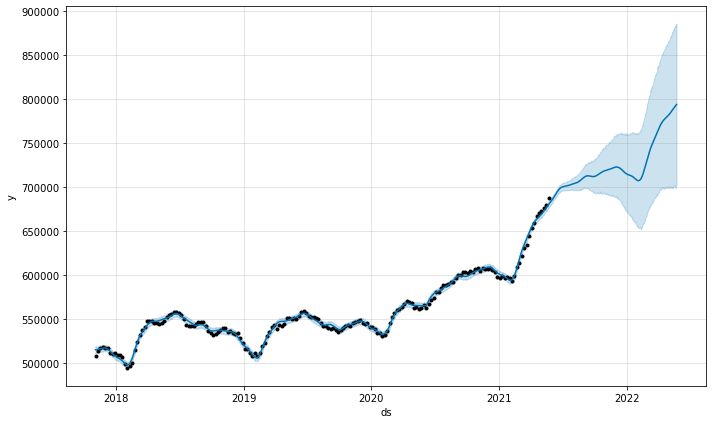

In [62]:
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
model.plot(forecast)
plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


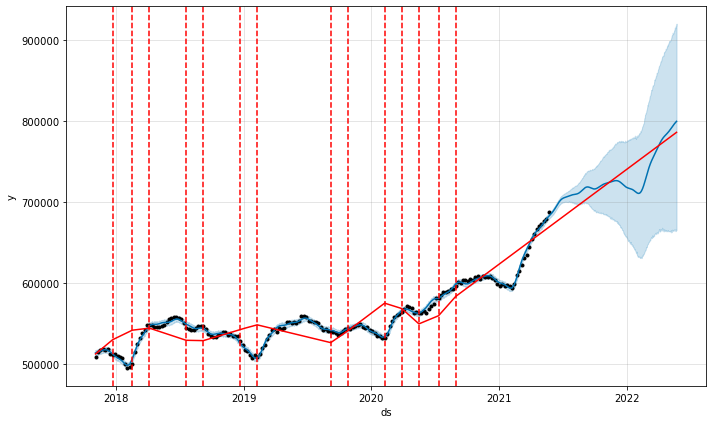

In [64]:
# messing with change_point scaling to double check the tight grouping in previous graph
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08) 
forecast = pro_change.fit(df_2).predict(future)
fig= pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [65]:
forecast.to_csv("california_forecast.csv")

In [66]:
df_3 = pd.DataFrame(columns = ["ds", "y"]) # ds, and y are the "expected" options for columns in prophet, ds= datestamp
df_3["ds"] = df_united_states.loc[:, "date"]  # changing the dataframe here and the line below will change output
df_3["y"] = df_united_states.loc[:, "sale_price"] # change column name for more models
model = Prophet(daily_seasonality = True, yearly_seasonality = True)
# fit the model
model.fit(df_3)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


             ds           yhat     yhat_lower     yhat_upper
2200 2022-05-18  374860.337126  304466.797686  440197.610051
2201 2022-05-19  375223.454025  304270.654658  441272.421732
2202 2022-05-20  375597.467533  303970.629553  441031.725885
2203 2022-05-21  375981.413213  304802.795916  442537.266784
2204 2022-05-22  376374.228131  305223.745511  443488.899292


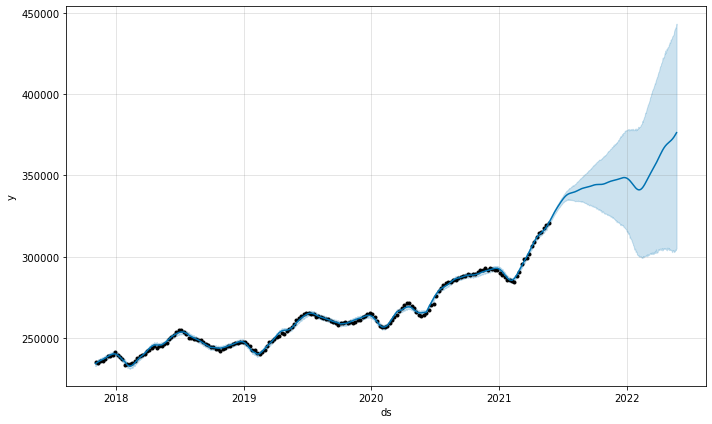

In [67]:
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
model.plot(forecast)
plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


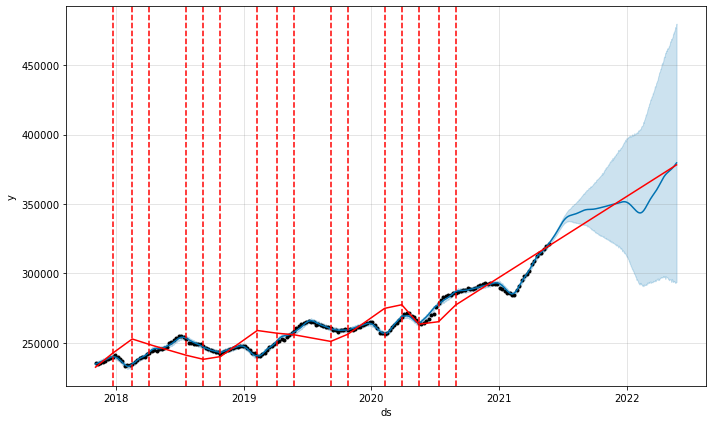

In [68]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08) 
forecast = pro_change.fit(df_3).predict(future)
fig= pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [69]:
forecast.to_csv("united_states_forecast.csv")